In [80]:
from evo.tools import log
log.configure_logging()
from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation
from evo.core.units import Unit
from evo.tools.settings import SETTINGS

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

plt.style.use('default')
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.size": 11,
        "font.family": "lmodern",
        "legend.fontsize": "x-small",
        "figure.figsize": (15, 5),
        "axes.labelsize": "x-small",
        "axes.titlesize": "x-small",
        "xtick.labelsize": "xx-small",
        "ytick.labelsize": "xx-small",
    }
)

# interactive widgets configuration
import ipywidgets
import json

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

agent_ids = [1]
bag_name = "/home/joshuabird/Desktop/apr13_lab_dataset_b"

with open("mocap_calibrations.json", "r") as json_file:
    mocap_calibrations = json.load(json_file)

In [81]:
from evo.tools import file_interface
from rosbags.rosbag2 import Reader as Rosbag2Reader
from rosbags.serde import deserialize_cdr
import math
import numpy as np
from scipy.spatial.transform import Rotation
from pathlib import Path
import os
from rosbags.typesys import get_types_from_idl, get_types_from_msg, register_types
import copy

# Add custom types
interfaces_dir = "../interfaces/msg/"
for file in os.listdir(interfaces_dir):
    msg_text = Path(interfaces_dir + file).read_text()
    register_types(get_types_from_msg(msg_text, "interfaces/msg/"+file[:-4]))


/tmp/ipykernel_56468/89671298.py:16: DeprecationWarning: Global type registration has been replaced with explicit typestores.

Perform all type registration and subsequent serialization and
deserialization on typestore instances:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.register(types)
  register_types(get_types_from_msg(msg_text, "interfaces/msg/"+file[:-4]))


In [82]:
from evo.tools import file_interface
from rosbags.rosbag2 import Reader as Rosbag2Reader
from rosbags.serde import deserialize_cdr
import numpy as np

traj_ests = {}
with Rosbag2Reader(bag_name) as reader:
    # Read the trajectory and ground truth for each agent
    for agent_id in agent_ids:
        traj_est = file_interface.read_bag_trajectory(reader, f"/robot{agent_id}/camera_pose")
        traj_est.timestamps += 0

        traj_ests[agent_id] = traj_est

In [83]:
from evo.core.trajectory import PosePath3DElement

filter_func: PosePath3DElement = lambda element: element["coord_frame"] == "robot1/origin"

# Filter to only the time range where trajectories are merged
for agent_id in agent_ids:
    traj_ests[agent_id].filter(filter_func)

1215 poses, 11.745m path length, 109.400s duration


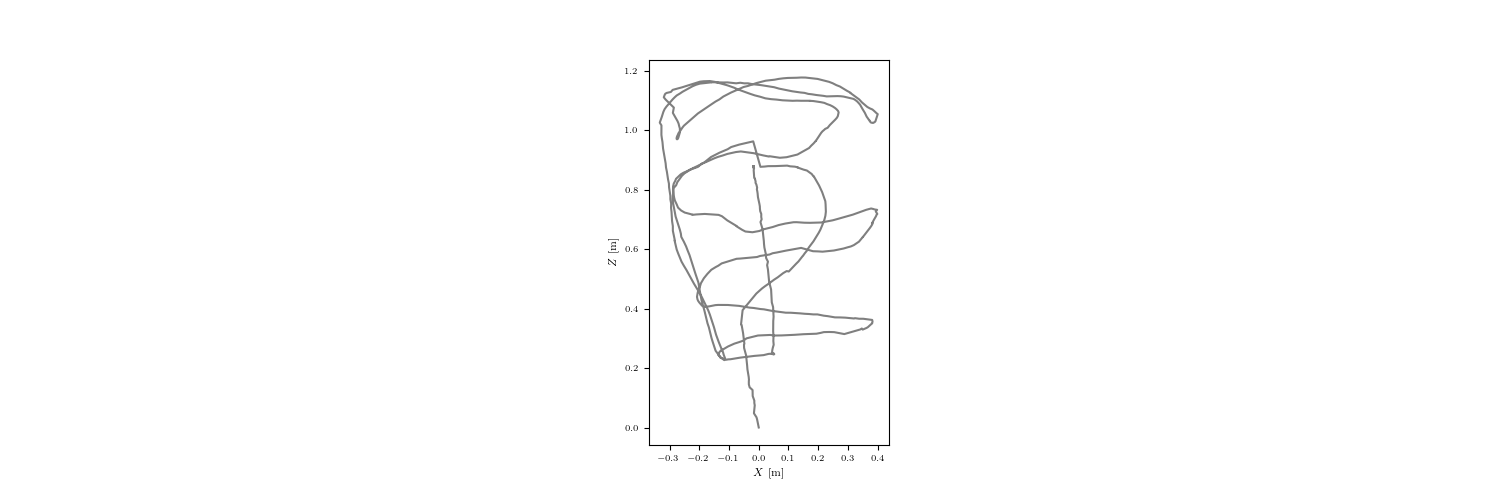

In [84]:
for agent_id in agent_ids:
    print(traj_ests[agent_id])

fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode=PlotMode.xz)

for agent_id in agent_ids:
    plot.traj(ax, PlotMode.xz, traj_ests[agent_id], alpha=0.5)

In [85]:
from geometry_msgs.msg import PoseStamped
from tf2_msgs.msg import TFMessage
from evo.core.trajectory import PosePath3D, PoseTrajectory3D

traj_refs = {}
frame_id_to_agent_id = {
    "robomaster_0": 1,
    "robomaster_1": 2,
}

xyz = {agent_id:[] for agent_id in agent_ids}
quat = {agent_id:[] for agent_id in agent_ids}
stamps = {agent_id:[] for agent_id in agent_ids}

with Rosbag2Reader(bag_name) as reader:
    # Read TF ground truth
    topic = "/tf"
    connections = [c for c in reader.connections if c.topic == topic]
    for connection, _, rawdata in reader.messages(connections=connections):
        data = deserialize_cdr(rawdata, connection.msgtype)

        for transform in data.transforms:
            if transform.child_frame_id in frame_id_to_agent_id:
                agent_id = frame_id_to_agent_id[transform.child_frame_id]

                xyz[agent_id].append([transform.transform.translation.x, transform.transform.translation.y, transform.transform.translation.z])
                quat[agent_id].append([transform.transform.rotation.w, transform.transform.rotation.x, transform.transform.rotation.y, transform.transform.rotation.z])
                t = transform.header.stamp
                stamps[agent_id].append(t.sec + (t.nanosec * 1e-9))
        
for agent_id in agent_ids:
    traj_refs[agent_id] = PoseTrajectory3D(np.array(xyz[agent_id]), np.array(quat[agent_id]), np.array(stamps[agent_id]))

# correct robomaster mocap data
for agent_id in agent_ids:
    rotation = mocap_calibrations[f"robomaster_{agent_id-1}"]["rotation"]
    rotation_matrix = Rotation.from_quat([rotation["x"], rotation["y"], rotation["z"], rotation["w"]]).as_matrix()
    rotation_matrix_4x4 = np.eye(4)
    rotation_matrix_4x4[:3, :3] = rotation_matrix

    translation_matrix_4x4 = np.eye(4)
    translation = mocap_calibrations[f"robomaster_{agent_id-1}"]["translation"]
    translation_matrix_4x4[:3, 3] = [translation["x"], translation["y"], translation["z"]]
    
    transform = rotation_matrix_4x4 @ translation_matrix_4x4

    traj_refs[agent_id].transform(transform, right_mul=True)


/tmp/ipykernel_56468/3537697731.py:20: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  data = deserialize_cdr(rawdata, connection.msgtype)


4310 poses, 64.236m path length, 144.834s duration


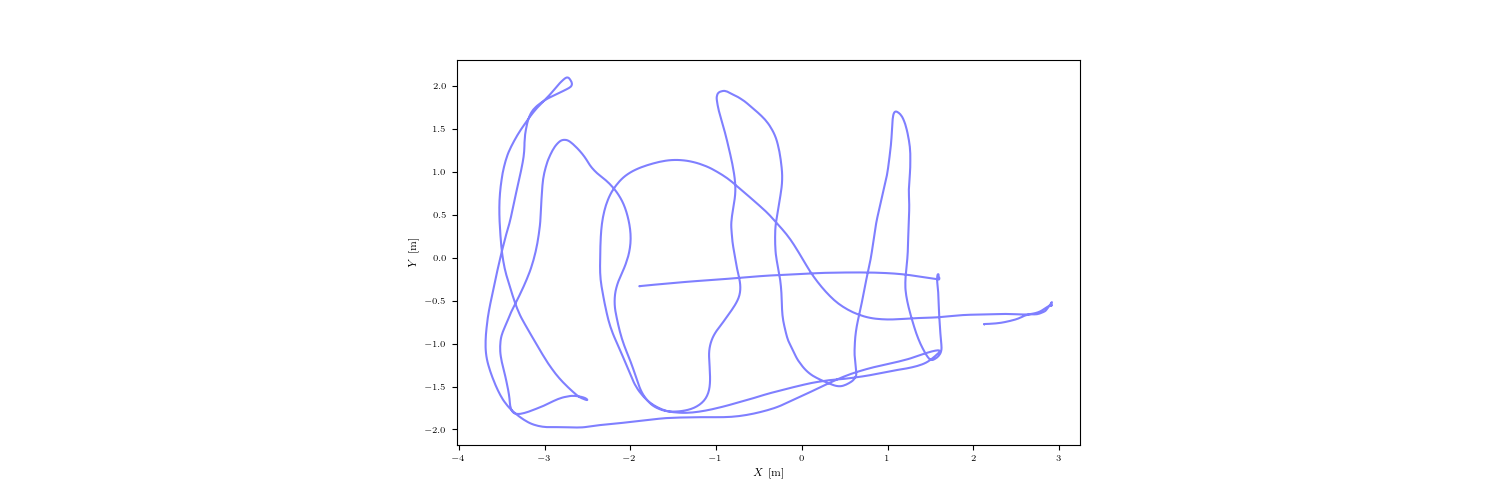

In [86]:
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode=PlotMode.xy)

for agent_id in agent_ids:
    print(traj_refs[agent_id])
    plot.traj(ax, PlotMode.xy, traj_refs[agent_id], color="blue", alpha=0.5)

In [87]:
# Example 1
# start_time = 1711402122
# end_time = 1711402128

# 4 trials
# start_time = 1711402122-73
# end_time = 1711402128+5

# # Example 2
# # start_time = 1711401899
# # end_time = 1711401906

# for agent_id in agent_ids:
#     traj_refs[agent_id].reduce_to_time_range(start_time, end_time)
#     traj_ests[agent_id].reduce_to_time_range(start_time, end_time)

In [88]:
from evo.core import sync
from evo.core.trajectory import align_multiple
from sensor_msgs_py.point_cloud2 import read_points

max_diff = 0.1

traj_refs_ass = {}
traj_ests_ass = {}

for agent_id in agent_ids:
    traj_refs_ass[agent_id], traj_ests_ass[agent_id] = sync.associate_trajectories(traj_refs[agent_id], traj_ests[agent_id], max_diff)
    
rotation_matrix, translation_vector, scale = align_multiple(list(traj_ests_ass.values()), list(traj_refs_ass.values()), correct_scale=True)

transform = np.eye(4)

transform[:3, :3] = rotation_matrix
transform[:3, :3] = scale * rotation_matrix
transform[:3, 3] = translation_vector.reshape(3)

print(rotation_matrix, translation_vector, scale)



[[ 0.07161658  0.01492268 -0.9973206 ]
 [ 0.99631984 -0.04828014  0.07082231]
 [-0.04709392 -0.99872235 -0.01832542]] [ 2.89561729 -0.53359729  1.08347597] 5.508794118698666


In [89]:
from rclpy.serialization import deserialize_message
from visualization_msgs.msg import MarkerArray, Marker
from sensor_msgs.msg import PointCloud2

viz_msgs = {}

type_converter = {
    "visualization_msgs/msg/MarkerArray": MarkerArray,
    "visualization_msgs/msg/Marker": Marker,
    "sensor_msgs/msg/PointCloud2": PointCloud2
}

with Rosbag2Reader(bag_name) as reader:
    # Read visuzalization data
    robot_names = [f"robot{agent_id}" for agent_id in agent_ids]
    topics = [f'/{robot_name}/all_points' for robot_name in robot_names] + \
            [f'/{robot_name}/kf_markers' for robot_name in robot_names] + \
            [f'/{robot_name}/camera_pose_marker' for robot_name in robot_names] + \
            [f'/{robot_name}/tracked_points' for robot_name in robot_names]
            
    connections = [c for c in reader.connections if c.topic in topics]
    for connection, timestamp, rawdata in reader.messages(connections=connections):
        type_def = type_converter[connection.msgtype]
        data = deserialize_message(rawdata, type_def)

        if connection not in viz_msgs:
            viz_msgs[connection] = []

        viz_msgs[connection].append({"timestamp": timestamp, "data": data})
        
def process_marker(marker):
    marker.header.frame_id = "map"
    
    position = [marker.pose.position.x, marker.pose.position.y, marker.pose.position.z]
    quaternion = [marker.pose.orientation.x, marker.pose.orientation.y, marker.pose.orientation.z, marker.pose.orientation.w]

    rotation_matrix = Rotation.from_quat(quaternion).as_matrix()
    matrix_4x4 =  np.eye(4)
    matrix_4x4[:3, :3] = rotation_matrix
    matrix_4x4[:3, 3] = position

    scale = 0.3

    # rly dumb, we need to handle differently depending if the pose or the points define the locations
    if (matrix_4x4 == np.eye(4)).all():
        for point in marker.points:
            p = np.array([point.x, point.y, point.z, 1])
            new_point = transform @ p
            point.x, point.y, point.z = new_point[:3] / new_point[3]
    else:
        new_matrix_4x4 = transform @ matrix_4x4
        new_quaterion = Rotation.from_matrix(new_matrix_4x4[:3, :3]).as_quat()

        for point in marker.points:
            p = np.array([point.x, point.y, point.z, 1])
            # scale matrix
            scale_mat = np.array([
                [scale,0,0,0],
                [0,scale,0,0],
                [0,0,scale,0],
                [0,0,0,1]
            ])
            
            new_point = new_matrix_4x4 @ scale_mat @ p
            point.x, point.y, point.z = new_point[:3] / new_point[3]

        marker.pose.position.x, marker.pose.position.y, marker.pose.position.z = [0.,0.,0.]
        marker.pose.orientation.x, marker.pose.orientation.y, marker.pose.orientation.z, marker.pose.orientation.w = [0.,0.,0.,1.]

    if marker.ns == "keyFrameWireframes" or marker.ns == "cameraPoseWireframe":

        marker.scale.x *= scale * 5
        marker.scale.y *= scale * 5
        marker.scale.z *= scale * 5

        if marker.color.r == 0.5:
            marker.color.r = 255/255
            marker.color.g = 72/255
            marker.color.b = 72/255
            marker.color.a = 1.
        if marker.color.g == 0.5:
            marker.color.r = 72/255
            marker.color.g = 230/255
            marker.color.b = 72/255
            marker.color.a = 1.

    if marker.ns == "connectedKeyFrameLines":
        marker.color.r = 0.
        marker.color.g = 0.
        marker.color.b = 1.
        marker.color.a = .5

        marker.scale.x *= scale
        marker.scale.y *= scale
        marker.scale.z *= scale

# correct viz data
for connection, msgs in viz_msgs.items():
    if connection.msgtype == "visualization_msgs/msg/Marker":
        for msg in msgs:
            process_marker(msg["data"])

    elif connection.msgtype == "visualization_msgs/msg/MarkerArray":
        for msg in msgs:
            for marker in msg["data"].markers:
                process_marker(marker)

    elif connection.msgtype == "sensor_msgs/msg/PointCloud2":
        for msg in msgs:
            msg["data"].header.frame_id = "map"
            for p in read_points(msg["data"], field_names = ("x", "y", "z"), skip_nans=True):
                point = np.array([p[0], p[1], p[2], 1])
                new_point = transform @ point
                p[0], p[1], p[2] = new_point[:3] / new_point[3]

In [90]:
for agent_id in agent_ids:
    print(traj_refs_ass[agent_id])
    print(traj_ests_ass[agent_id])
    print()

1215 poses, 62.510m path length, 109.401s duration
1215 poses, 64.699m path length, 109.400s duration



In [91]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    fig = plt.figure(figsize=(6.7 * 0.4,2.9))
    ax = plot.prepare_axis(fig, plot_mode)
    overall_min = np.inf
    overall_max = -np.inf
    
    for agent_id in agent_ids:
        traj_refs_ass[agent_id]._positions_xyz = traj_refs_ass[agent_id].positions_xyz[:, [1, 0, 2]]
        traj_ests_ass[agent_id]._positions_xyz = traj_ests_ass[agent_id].positions_xyz[:, [1, 0, 2]]

        result = main_ape.ape(traj_refs_ass[agent_id], traj_ests_ass[agent_id], est_name=est_name,
                              pose_relation=pose_relation, align=align, correct_scale=correct_scale)
        results.append(result)
        if result.stats["min"] < overall_min:
            overall_min = result.stats["min"]
        if result.stats["max"] > overall_max:
            overall_max = result.stats["max"]

        if show_plot:
            plot.traj(ax, plot_mode, traj_refs_ass[agent_id], style="--", alpha=0.5)
            plot.traj_colormap(
                ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
                min_map=overall_min, max_map=overall_max-0.3, color_bar_label="ATE [m]", show_color_bar=agent_id == agent_ids[-1])
            
            # plot.traj(ax, plot_mode, cam_traj)
    count += 1
    
    plt.tight_layout()
    ax.set_aspect("equal")
    ax.set_ylim(None, 3.6)
    plt.legend([f"Ground Truth", f"Estimate"], loc="upper right", fontsize="xx-small")

    print(f"Overall RMS ATE: {np.sqrt(np.mean(np.concatenate([result.np_arrays['error_array'] for result in results])**2))}")

    # save as file
    if show_plot:
        fig.savefig(f'figures_output/{bag_name.split("/")[-1]}_trajectory.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01)
    
    
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

In [115]:
tf_messages = []

# Define smoothing factor
alpha = 0.5  # You can adjust this value based on the desired smoothing level

# Dictionary to store previous translations and rotations
prev_translations = {}
prev_rotations = {}

# Function to apply exponential moving average smoothing
def smooth_data(new_data, prev_data):
    if not prev_data:
        return new_data
    else:
        smoothed_data = [(1 - alpha) * prev + alpha * new for prev, new in zip(prev_data, new_data)]
        return smoothed_data
    

with Rosbag2Reader(bag_name) as reader:
    # Read tf data
    topic = "/tf"
    connections = [c for c in reader.connections if c.topic in topic]
    for connection, timestamp, rawdata in reader.messages(connections=connections):
        data = deserialize_cdr(rawdata, connection.msgtype)

        if connection.msgtype == "tf2_msgs/msg/TFMessage":
            for transform in data.transforms:
                if transform.child_frame_id == "rpi_cam_0":
                    translation = [transform.transform.translation.x, transform.transform.translation.y, transform.transform.translation.z]
                    quaterion = [transform.transform.rotation.x, transform.transform.rotation.y, transform.transform.rotation.z, transform.transform.rotation.w]

                    # Smooth translation
                    if connection not in prev_translations:
                        prev_translations[connection] = None
                    smoothed_translation = smooth_data(translation, prev_translations[connection])
                    prev_translations[connection] = smoothed_translation

                    # Smooth rotation
                    if connection not in prev_rotations:
                        prev_rotations[connection] = None
                    smoothed_rotation = smooth_data(quaterion, prev_rotations[connection])
                    prev_rotations[connection] = smoothed_rotation

                    # Update translation and rotation
                    transform.transform.translation.x, transform.transform.translation.y, transform.transform.translation.z = smoothed_translation

                    # rotate smoothed_rotation 3 degrees around the x axis
                    rotation = Rotation.from_quat(smoothed_rotation)
                    rotation = rotation * Rotation.from_euler('x', -0.8, degrees=True)
                    smoothed_rotation = rotation.as_quat()
                    
                    transform.transform.rotation.x, transform.transform.rotation.y, transform.transform.rotation.z, transform.transform.rotation.w = smoothed_rotation

        tf_messages.append({"timestamp": timestamp, "data": data})

/tmp/ipykernel_56468/2603902041.py:24: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  data = deserialize_cdr(rawdata, connection.msgtype)


In [116]:
from collections import deque

camera_bag_data = {}


# Read data from camera bag
with Rosbag2Reader("/home/joshuabird/Desktop/apr13_lab_cam_b") as reader:
    for connection, timestamp, rawdata in reader.messages():
        data = deserialize_cdr(rawdata, connection.msgtype)
        if connection not in camera_bag_data:
            camera_bag_data[connection] = []

        if connection.msgtype == "sensor_msgs/msg/CompressedImage" or connection.msgtype == "sensor_msgs/msg/CameraInfo":
            timestamp -= 0.08 * 1e9

        camera_bag_data[connection].append({"timestamp": timestamp, "data": data})


/tmp/ipykernel_56468/4063212880.py:9: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  data = deserialize_cdr(rawdata, connection.msgtype)


In [117]:
from rosbags.rosbag2 import Writer as Rosbag2Writer
from rclpy.serialization import serialize_message
from rosbags.typesys.types import sensor_msgs__msg__CompressedImage, sensor_msgs__msg__CameraInfo, tf2_msgs__msg__TFMessage
from cv_bridge import CvBridge
import cv2
from sensor_msgs.msg import CameraInfo
from geometry_msgs.msg import TransformStamped
from rosbags.serde import serialize_cdr

# delete directory if it exists
if os.path.exists(f"{bag_name}_processed"):
    os.system(f"rm -rf {bag_name}_processed")


with Rosbag2Writer(f"{bag_name}_processed") as writer:
    # write new trajectories
    for agent_id in agent_ids:
        file_interface.write_bag_trajectory(writer, traj_ests_ass[agent_id], f"/robot{agent_id}/camera_pose", frame_id="map")
        file_interface.write_bag_trajectory(writer, traj_refs[agent_id], f"/robot{agent_id}/ground_truth_pose", frame_id="map")
        
    # write transformed viz data
    for connection, msgs in viz_msgs.items():
        new_connection = writer.add_connection(connection.topic, connection.msgtype)
        
        for msg in msgs:
            writer.write(new_connection, msg["timestamp"], serialize_message(msg["data"]))

    # write untransformed tf topic
    new_connection = writer.add_connection("/tf", "tf2_msgs/msg/TFMessage")
    for msg in tf_messages:
        writer.write(new_connection, msg["timestamp"], serialize_cdr(msg["data"], new_connection.msgtype))
    
    # write camera bag messages
    for connection, msgs in camera_bag_data.items():
        new_connection = writer.add_connection(connection.topic, connection.msgtype)
        
        for msg in msgs:
            writer.write(new_connection, msg["timestamp"], serialize_cdr(msg["data"], new_connection.msgtype))


Saved geometry_msgs/PoseStamped topic: /robot1/camera_pose
Saved geometry_msgs/PoseStamped topic: /robot1/ground_truth_pose


/tmp/ipykernel_56468/300842650.py:23: DeprecationWarning: Writer.add_connection should be called with typestore or msgdef/rihs01 pair.
  new_connection = writer.add_connection(connection.topic, connection.msgtype)
/tmp/ipykernel_56468/300842650.py:29: DeprecationWarning: Writer.add_connection should be called with typestore or msgdef/rihs01 pair.
  new_connection = writer.add_connection("/tf", "tf2_msgs/msg/TFMessage")
/tmp/ipykernel_56468/300842650.py:31: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  writer.write(new_connection, msg["timestamp"], serialize_cdr(msg["data"], new_connection.msgtype))
/tmp/ipykernel

In [118]:
import pandas as pd

data = []
for agent_id in agent_ids:
    for is_est, traj in enumerate([traj_refs[agent_id], traj_ests_ass[agent_id]]):
        timetamps = traj.timestamps
        positions_xyz = traj.positions_xyz
        orientations_quat_wxyz = traj.orientations_quat_wxyz

        for i in range(len(timetamps)):
            data.append({
                "timestamp": timetamps[i],
                "x": positions_xyz[i][0],
                "y": positions_xyz[i][1],
                "z": positions_xyz[i][2],
                "qw": orientations_quat_wxyz[i][0],
                "qx": orientations_quat_wxyz[i][1],
                "qy": orientations_quat_wxyz[i][2],
                "qz": orientations_quat_wxyz[i][3],
                "topic": f"/robot{agent_id}/camera_pose" if is_est == 1 else f"/robot{agent_id}/ground_truth_pose"
            })


df = pd.DataFrame(data)

df["timestamp"] = df["timestamp"] - df["timestamp"].min() - 0.1
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

df.to_csv(f"{bag_name}_processed.csv", index=False)

df[(df["topic"] == "/robot1/ground_truth_pose")]["timestamp"]

0      1969-12-31 23:59:59.900000000
1      1969-12-31 23:59:59.932968283
2      1969-12-31 23:59:59.966398144
3      1969-12-31 23:59:59.999866152
4      1970-01-01 00:00:00.033185148
                    ...             
4305   1970-01-01 00:02:24.600837135
4306   1970-01-01 00:02:24.634380006
4307   1970-01-01 00:02:24.666890048
4308   1970-01-01 00:02:24.700972700
4309   1970-01-01 00:02:24.734141731
Name: timestamp, Length: 4310, dtype: datetime64[ns]

/tmp/ipykernel_56468/588991869.py:30: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  est_1_upsampled = est_1.set_index("timestamp").resample("10ms").first().interpolate("linear").reset_index()


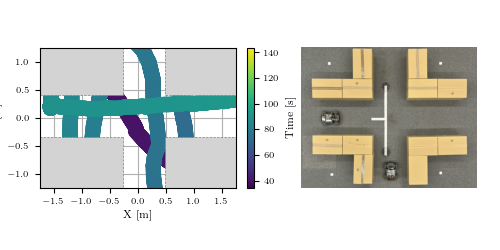

In [33]:
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import seaborn as sns

color_palette = sns.color_palette('Set1', 120)



# fig = plt.figure(figsize=(5, 5))
# ax1 = fig.add_subplot(111, projection='3d', computed_zorder=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[5.0, 2.5], gridspec_kw={'width_ratios': [1.22, 1]})
fig.tight_layout()

# Intersection example
# start_time = 1711402122
# end_time = 1711402128

# push back and forth example
# start_time = 1711401965
# end_time = 1711401990

ref_1 = df[(df["topic"] == "/robot1/ground_truth_pose")]# & (df["timestamp"] > start_time) & (df["timestamp"] < end_time)]
ref_2 = df[(df["topic"] == "/robot2/ground_truth_pose")]# & (df["timestamp"] > start_time) & (df["timestamp"] < end_time)]
# ax1.plot(-ref_1['x'].values, -ref_1['y'].values, c="orange", alpha=1, zorder=100, linestyle=":", label="Ground Truth")
# ax1.plot(-ref_2['x'].values, -ref_2['y'].values, c="orange", alpha=1, zorder=100, linestyle=":")

est_1 = df[(df["topic"] == "/robot1/camera_pose")]# & (df["timestamp"] > start_time) & (df["timestamp"] < end_time)]
est_2 = df[(df["topic"] == "/robot2/camera_pose")]# & (df["timestamp"] > start_time) & (df["timestamp"] < end_time)]
est_1_upsampled = est_1.set_index("timestamp").resample("10ms").first().interpolate("linear").reset_index()
est_2_upsampled = est_2.set_index("timestamp").resample("10ms").first().interpolate("linear").reset_index()

ax1.scatter(-est_1_upsampled['x'].values, -est_1_upsampled['y'].values, c=est_1_upsampled['timestamp'].astype(int).values/1e9, cmap="viridis", alpha=1, s=100)#, s=2500*0.07*scale)
ax1.scatter(-est_2_upsampled['x'].values, -est_2_upsampled['y'].values, c=est_2_upsampled['timestamp'].astype(int).values/1e9, cmap="viridis", alpha=1, s=100)#, s=2500*0.07*scale)

plt.colorbar(ax1.collections[0], ax=ax1, orientation="vertical", label="Time [s]", fraction=0.0328)

x_left, x_right, y_bottom, y_top = -0.275, 0.475, -0.35, 0.4
rect_1 = patches.Rectangle((x_right, y_top), 10, 10, linewidth=0.5, edgecolor='grey', facecolor='lightgrey', linestyle="--")
rect_2 = patches.Rectangle((x_left, y_top), -10, 10, linewidth=0.5, edgecolor='grey', facecolor='lightgrey', linestyle="--")
rect_3 = patches.Rectangle((x_right, y_bottom), 10, -10, linewidth=0.5, edgecolor='grey', facecolor='lightgrey', linestyle="--")
rect_4 = patches.Rectangle((x_left, y_bottom), -10, -10, linewidth=0.5, edgecolor='grey', facecolor='lightgrey', linestyle="--")
ax1.add_patch(rect_1)
ax1.add_patch(rect_2)
ax1.add_patch(rect_3)
ax1.add_patch(rect_4)

ax1.set_aspect("equal")
ax1.set_xbound(-1.75, 1.75)
ax1.set_ybound(-1.25, 1.25)
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.grid()
ax1.set_axisbelow(True)
# ax1.legend(loc='upper right')

ax2.imshow(plt.imread("setup.png"), interpolation=None)
ax2.axis('off')


# Showing plot
plt.show()

fig.savefig("traj_collision_avoidance.pdf", bbox_inches='tight', dpi=300, pad_inches=0.01)

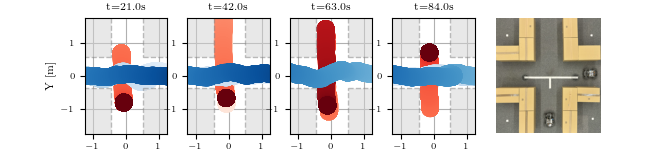

In [23]:
timesteps = 4
timestep = (est_1_upsampled["timestamp"].max() - est_1_upsampled["timestamp"].min()) / timesteps
start_time_datetime = est_1_upsampled["timestamp"].min()

fig, axs = plt.subplots(1, timesteps+1, figsize=(6.7, 1.5), sharex=False, sharey=False, gridspec_kw={'width_ratios': [1]*timesteps + [1.29]})

for i in range(timesteps):

    est_1_timestep = est_1_upsampled[(est_1_upsampled["timestamp"] > start_time_datetime + timestep*i) & (est_1_upsampled["timestamp"] < start_time_datetime + timestep*(i+1))]
    est_2_timestep = est_2_upsampled[(est_2_upsampled["timestamp"] > start_time_datetime + timestep*i) & (est_2_upsampled["timestamp"] < start_time_datetime + timestep*(i+1))]

    axs[i].scatter(est_1_timestep["y"].values, -est_1_timestep["x"].values, c=est_1_timestep.index, cmap="Reds", alpha=1, s=490*0.07*scale)
    axs[i].scatter(est_2_timestep["y"].values, -est_2_timestep["x"].values, c=est_2_timestep.index, cmap="Blues", alpha=1, s=490*0.07*scale)

    rect_1 = patches.Rectangle((0.5, 0.575), 10, 10, linewidth=1, edgecolor='grey', facecolor='lightgrey', linestyle="--", alpha=0.5)
    rect_2 = patches.Rectangle((-0.45, 0.575), -10, 10, linewidth=1, edgecolor='grey', facecolor='lightgrey', linestyle="--", alpha=0.5)
    rect_3 = patches.Rectangle((0.5, -0.375), 10, -10, linewidth=1, edgecolor='grey', facecolor='lightgrey', linestyle="--", alpha=0.5)
    rect_4 = patches.Rectangle((-0.45, -0.375), -10, -10, linewidth=1, edgecolor='grey', facecolor='lightgrey', linestyle="--", alpha=0.5)
    axs[i].add_patch(rect_1)
    axs[i].add_patch(rect_2)
    axs[i].add_patch(rect_3)
    axs[i].add_patch(rect_4)

    axs[i].set_title(f"t={round((timestep*(i+1)).total_seconds()*2)/2}s")
    axs[i].set_aspect("equal")
    axs[i].set_xbound(-1.25, 1.25)
    axs[i].set_ybound(-1.75, 1.75)
    axs[i].set_xlabel("X [m]")
    if i == 0: axs[i].set_ylabel("Y [m]")
    axs[i].grid()
    axs[i].set_axisbelow(True)


axs[-1].imshow(np.rot90(plt.imread("setup.png"))[90:-90, 20:-20], interpolation=None)
axs[-1].axis('off')

# Showing plot
plt.show()

fig.savefig(f"figures_output/{bag_name.split('/')[-1]}_tracer_graph.pdf", bbox_inches='tight', pad_inches=0, dpi=300)

In [24]:
import colorsys

def shift_lightness(rgb, shift_amount):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    
    l = max(0, min(1, l + shift_amount))
    
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    
    return (r, g, b)

In [25]:
ref_1 = ref_1.sort_values("timestamp")
ref_2 = ref_2.sort_values("timestamp")

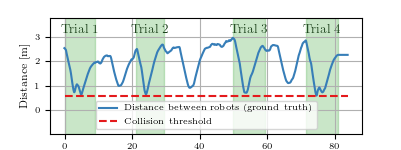

In [50]:
est_1_2 = pd.merge_asof(ref_1, ref_2, on="timestamp", direction='nearest', suffixes=('_1', '_2'))

dist = np.linalg.norm(est_1_2[['x_1', 'y_1']].values - est_1_2[['x_2', 'y_2']], axis=1)

fig = plt.figure(figsize=(6.7 * 0.6, 1.5))
ax = fig.add_subplot(111)

ax.plot((est_1_2["timestamp"].astype(int).values/1e9), dist+0.1, label="Distance between robots (ground truth)", color=color_palette[1])
ax.hlines(0.07*scale*2, 0, (est_1_2["timestamp"].astype(int).values/1e9).max(), colors=color_palette[0], linestyles="dashed", label="Collision threshold")
ax.set_ybound(-0.99, 3.8)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Distance [m]")
ax.grid()
ax.legend(loc="lower center", fontsize="xx-small")


# Shade and label time chunks
trial_intervals = [(0, 9), (21, 29.5), (50, 59.5), (71.5, 81)]  # Example time chunks to shade

for i, (start, end) in enumerate(trial_intervals):
    ax.axvspan(start, end, color=color_palette[2], alpha=0.3)
    ax.text((start + end) / 2, 3.15, f"Trial {i+1}", ha='center', color=shift_lightness(color_palette[2], -0.3), fontsize="small")

plt.show()

fig.savefig(f"figures_output/{bag_name.split('/')[-1]}_distance_plot.pdf", bbox_inches='tight', pad_inches=0)


In [71]:
0.07*scale*2

0.5495877456969553

In [5]:
import numpy as np
cam_traj_xyz = []
cam_traj_quat = []

with Rosbag2Reader("/home/joshuabird/Desktop/rpi_cam_0_tf") as reader:
    topic = "/tf"
    connections = [c for c in reader.connections if c.topic == topic]
    for connection, _, rawdata in reader.messages(connections=connections):
        data = deserialize_cdr(rawdata, connection.msgtype)

        for transform in data.transforms:
            if transform.child_frame_id == "rpi_cam_0":
                cam_traj_xyz.append([transform.transform.translation.x, transform.transform.translation.y, transform.transform.translation.z])
                cam_traj_quat.append([transform.transform.rotation.x, transform.transform.rotation.y, transform.transform.rotation.z, transform.transform.rotation.w])

transform = np.array(cam_traj_xyz).mean(axis=0)

transform[2] -= 0.035 # rpi_cam offset

rotation_matrices = Rotation.from_quat(cam_traj_quat).as_matrix()
mean_rotation = np.mean(rotation_matrices, axis=0)

transformation = np.eye(4)
transformation[:3, :3] = mean_rotation
transformation[:3, 3] = transform

inv_transformation = np.linalg.inv(transformation)

inv_translation = inv_transformation[:3, 3]

rotation_offset = Rotation.from_euler("zyx", [0, np.deg2rad(0), np.deg2rad(-1.5)])
inv_rotation = (Rotation.from_matrix(inv_transformation[:3, :3]) * rotation_offset).as_quat()

print(inv_translation)
print(f'"x":{inv_rotation[0]}, \n\t\t"y":{inv_rotation[1]}, \n\t\t"z":{inv_rotation[2]}, \n\t\t"w":{inv_rotation[3]},')

/tmp/ipykernel_52222/18331704.py:9: DeprecationWarning: Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)
  data = deserialize_cdr(rawdata, connection.msgtype)


[ 0.03191756  0.03003872 -0.00353984]
"x":-0.003151266739461271, 
		"y":-0.0007847643165206752, 
		"z":0.0003586921092812441, 
		"w":0.999994662487193,
